 # Fake News Detection

## Importing Required Modules and Datasets

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,  Embedding, LSTM, Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from flask_ngrok import run_with_ngrok
from flask import Flask

## Reading the Training Datasets

In [5]:
data_frame_true = pd.read_csv('True.csv')
data_frame_fake = pd.read_csv('Fake.csv')

In [6]:
'''
Creating a column in both dataFrames called is_it_fake, which is 
set to 0 if it is fake
set to 1 if it is not fake
'''

data_frame_true['isfake'] = 0
data_frame_fake['isfake'] = 1

In [7]:
data_frame = pd.concat([data_frame_true, data_frame_fake])

In [8]:
data_frame.head()

,title,text,subject,date,isfake
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0


## Exploratory Data Analysis (EDA)

In [9]:
data_frame.drop('date', axis=1, inplace=True)

In [10]:
data_frame['text'] = data_frame['title']+data_frame['text']
data_frame.drop(columns=['title'], inplace=True)
data_frame.head()

,text,subject,isfake
0,"As U.S. budget fight looms, Republicans flip t...",politicsNews,0
1,U.S. military to accept transgender recruits o...,politicsNews,0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,politicsNews,0
3,FBI Russia probe helped by Australian diplomat...,politicsNews,0
4,Trump wants Postal Service to charge 'much mor...,politicsNews,0


## Data Cleaning

In [11]:
# Stopwords are those which occur very frequently such that they don't have much importance.
stopwords = stopwords.words('english') + ['from', 'subject', 're', 'edu', 'use']

In [12]:
# This function removes all the stopwords from a string and return the list of remaining words.
def preprocess(string):
    words = []
    for i in simple_preprocess(string):
        if i not in STOPWORDS and len(i)>3 and i not in stopwords:
            words.append(i)
    return words

In [13]:
data_frame['text'] = data_frame['text'].map(preprocess)

In [14]:
data_frame['text'] = data_frame['text'].map(lambda x:' '.join(x))
data_frame.head()

,text,subject,isfake
0,budget fight looms republicans flip fiscal reu...,politicsNews,0
1,military accept transgender recruits monday re...,politicsNews,0
2,senior republican senator mueller washington r...,politicsNews,0
3,russia probe helped australian diplomat nytwas...,politicsNews,0
4,trump wants postal service charge amazon washi...,politicsNews,0


In [15]:
unq_words = set()
for doc in data_frame.text:
    for i in doc.split():
        unq_words.add(i)

In [16]:
# Finding the maximum no. of words in a text.
maxlen = 0
for i in data_frame.text:
    tokens = nltk.word_tokenize(i)
    maxlen = max(len(tokens), maxlen)

In [21]:
maxlen

4406

## Preparing the data for training and testing

In [17]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data_frame.text, data_frame.isfake, test_size=0.2)

In [18]:
# Tokenizer encodes each string to a unique integer so that we can train our model
tokenizer = Tokenizer(num_words=len(unq_words))
tokenizer.fit_on_texts(x_train)
train_seq = tokenizer.texts_to_sequences(x_train)
test_seq = tokenizer.texts_to_sequences(x_test)

In [19]:
padded_train = pad_sequences(train_seq, maxlen=maxlen, padding='post', truncating='post')
padded_test = pad_sequences(test_seq, maxlen=maxlen, padding='post', truncating='post')

In [20]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.5.0
Running on TPU  ['10.36.136.26:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.36.136.26:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.36.136.26:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


## Creating and training the model

In [21]:
model = Sequential()

model.add(Embedding(len(unq_words), output_dim=128))

model.add(Bidirectional(LSTM(128)))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         15743488  
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               263168    
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 16,039,681
Trainable params: 16,039,681
Non-trainable params: 0
_________________________________________________________________


In [22]:
y_train = np.asarray(y_train)

In [23]:
hist=model.fit(padded_train, y_train, batch_size=64*8, validation_split=0.1, epochs=2)

Epoch 1/2
64/64 [==============================] - 1384s 22s/step - loss: 0.2267 - accuracy: 0.9099 - val_loss: 0.0206 - val_accuracy: 0.9925
Epoch 2/2
64/64 [==============================] - 1375s 21s/step - loss: 0.0048 - accuracy: 0.9984 - val_loss: 0.0100 - val_accuracy: 0.9958


In [25]:
model.save('chatbot_model.h5', hist)


In [79]:
!mkdir -p saved_modell
model.save_weights('saved_model/my_model')

## Testing the trained model

In [ ]:
pred_prob = model.predict(padded_test)

In [ ]:
pred = list(map(lambda x:1 if x>0.5 else 0, pred_prob))

In [ ]:
print('sklearn.metrics.accuray_score:', accuracy_score(np.asarray(y_test), np.array(pred)))

sklearn.metrics.accuray_score: 0.9959910913140312


In [ ]:
model.evaluate(padded_test, np.asarray(y_test))

sklearn.metrics.accuray_score: 0.5202672605790646
  2/281 [..............................] - ETA: 3:54 - loss: 0.0102 - accuracy: 1.0000WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0010s vs `on_test_batch_end` time: 0.7956s). Check your callbacks.


281/281 [==============================] - 210s 748ms/step - loss: 0.0110 - accuracy: 0.9960


[0.01102613378316164, 0.9959911108016968]

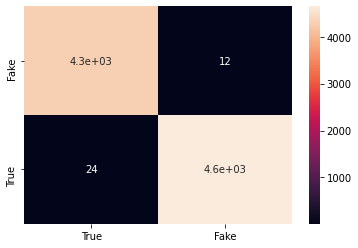

In [ ]:
# Visualizing the performance of our model.
cm = confusion_matrix(y_test, pred)
sns.heatmap(cm, annot=True, xticklabels=['True', 'Fake'], yticklabels=['Fake', 'True'])